In [1]:
#INSTALLING DEPENDENCIES
!pip install torch==1.12.1
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#IMPORT LIBRARIES
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import Accuracy
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#DATA LOADER:
horizontal_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5)])
batch_size=10000
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=horizontal_flip_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=horizontal_flip_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#UNPICKLING FILES INTO DICTIONARIES:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
dict1 = unpickle(file='./data/cifar-10-batches-py/data_batch_1')
dict2 = unpickle(file='./data/cifar-10-batches-py/data_batch_2')
dict3 = unpickle(file='./data/cifar-10-batches-py/data_batch_3')
dict4 = unpickle(file='./data/cifar-10-batches-py/data_batch_4')
dict5 = unpickle(file='./data/cifar-10-batches-py/data_batch_5')
dict_test = unpickle(file='./data/cifar-10-batches-py/test_batch')

#LOADING TRAIN AND TEST DATA
train_x1 = torch.tensor(dict1[b'data'])
train_y1 = torch.tensor(dict1[b'labels'])
train_x2 = torch.tensor(dict2[b'data'])
train_y2 = torch.tensor(dict2[b'labels'])
train_x3 = torch.tensor(dict3[b'data'])
train_y3 = torch.tensor(dict3[b'labels'])
train_x4 = torch.tensor(dict4[b'data'])
train_y4 = torch.tensor(dict4[b'labels'])
train_x5 = torch.tensor(dict5[b'data'])
train_y5 = torch.tensor(dict5[b'labels'])
test_x = torch.tensor(dict_test[b'data'])
test_y = torch.tensor(dict_test[b'labels'])

train_x = torch.cat((train_x1, train_x2, train_x3, train_x4, train_x5), dim=0)
train_y = torch.cat((train_y1, train_y2, train_y3, train_y4, train_y5), dim=0)
train_x = torch.reshape(train_x, (50000, 3, 32, 32))/255
test_x = torch.reshape(test_x, (10000, 3, 32, 32))/255

train_y_framed = torch.nn.functional.one_hot(train_y.clone().detach(), num_classes=10)
train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
test_y_framed = torch.nn.functional.one_hot(test_y.clone().detach(), num_classes=10)
test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-3-923f3ca44ac2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
<ipython-input-3-923f3ca44ac2>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


In [11]:
#DEFINING MODEL:
class Model1(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.con2 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.con2_1 = torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.gn1 = torch.nn.BatchNorm2d(128)
        self.drop1 = torch.nn.Dropout(p=0.25)
        self.con3 = torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.con4 = torch.nn.Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.gn2 = torch.nn.BatchNorm2d(64)
        self.f1 = torch.nn.Linear(4096, 512)
        self.drop2 = torch.nn.Dropout(p=0.5)
        self.f2 = torch.nn.Linear(512, 10)

    
    def forward(self,x):
        y = self.con1(x)
        y = torch.nn.functional.relu(y)
        y = self.con2(y)
        y = torch.nn.functional.relu(y)
        y = self.con2_1(y)
        # y = self.con2_2(y)
        y = self.pool(y)
        y = self.gn1(y)
        y = self.drop1(y)
        y = self.con3(y)
        y = torch.nn.functional.relu(y)
        y = self.con4(y)
        y = torch.nn.functional.relu(y)
        y = self.pool(y)
        y = self.gn2(y)  
        y = self.drop1(y)
        # print("Done 2")
        y = torch.reshape(y, (-1, 4096))
        y = self.f1(y)
        y = torch.nn.functional.relu(y)
        y = self.drop2(y)
        y = self.f2(y)
        # print("Done 3")
        return y    
class Ensemble(nn.Module):
    def __init__(self, m1, m2, m3, m4):
        super(Ensemble, self).__init__()
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.m4 = m4
        self.classifier = nn.Linear(40, 10)
        
    def forward(self, x1):
        xa = x1.clone().detach()
        x1 = self.m1(x1)
        # print("F!")
        x2 = self.m2(xa)
        x3 = self.m3(xa)
        x4 = self.m3(xa)
        # print("F!!")
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.classifier(torch.nn.functional.relu(x))
        return x  

#PARAMETERS:
epochs = 20
batch = 32
n_batches = 1562

In [12]:
#RUNNING THE MODEL ON TRAINING AND TESTING:
mymodel = Model1().to('cuda:0')
# mymodel = Ensemble(mymodel1, mymodel2, mymodel3, mymodel4).to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.001, weight_decay=0.001)
# LRS = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
val_loss = torch.empty(epochs)
train_loss = torch.empty(epochs)
valb = 32
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_t = np.zeros(epochs)
acc_v = np.zeros(epochs)
for epoch in range(epochs):
  rloss = 0
  acc = 0
  count = 0
  vloss = 0
  for b in range(n_batches):
  # for b in range(10):
    xbatch = train_x[(b)*batch:(b+1)*(batch)].to('cuda:0')
    ybatch = train_y_framed[(b)*batch:(b+1)*(batch)].to('cuda:0')
    predict = mymodel.forward(xbatch)
    loss = criterion(predict,ybatch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rloss+=loss.item()
  # LR1  = optimizer.param_groups[0]["lr"]
  # LRS.step()
  # LR2 = optimizer.param_groups[0]["lr"]
  # print(f'LR from {LR1} to {LR2}')
  predict_val = mymodel.forward(test_x[:1000].to('cuda:0'))
  loss2 = criterion(predict_val, test_y_framed[:1000].to('cuda:0')).item()
  print(f"Training Loss after epoch {epoch+1}: {rloss}")
  train_loss[epoch] = rloss
  val_loss[epoch] = loss2
  predict_val_v = mymodel.forward(test_x[:1000].to('cuda:0'))
  predict_val_t = mymodel.forward(train_x[:1000].to('cuda:0'))
  pred_labels_v = torch.argmax(predict_val_v, dim=1)
  pred_labels_t = torch.argmax(predict_val_t, dim=1)
  acc_t[epoch]= metric(pred_labels_t, train_y[:1000].to('cuda:0'))
  acc_v[epoch]=metric(pred_labels_v, test_y[:1000].to('cuda:0'))
  print(f'TRAIN_ACC: {acc_t[epoch]}')
  print(f'VAL ACC: {acc_v[epoch]}')
  ## Validation loss 
  print(f"Validation Loss after epoch {epoch+1}: {loss2}")
  # p1 = torch.argmax(predic,dim=1)
  # p2 = torch.argmax(test_y_framed[:500], dim=1)
  # count = torch.sum(p2)
  # val_accs[epoch] = torch.sum(torch.where(p1==p2,1,0))/count
  # print(f'Validation acc after epoch {epoch+1}: {val_accs[epoch]}')
print(acc_t)
print(acc_v)



Training Loss after epoch 1: 2063.082158267498
TRAIN_ACC: 0.628000020980835
VAL ACC: 0.6539999842643738
Validation Loss after epoch 1: 1.012221336364746
Training Loss after epoch 2: 1493.7732352018356
TRAIN_ACC: 0.6800000071525574
VAL ACC: 0.6769999861717224
Validation Loss after epoch 2: 0.9034289717674255
Training Loss after epoch 3: 1360.878988236189
TRAIN_ACC: 0.6949999928474426
VAL ACC: 0.7229999899864197
Validation Loss after epoch 3: 0.8368252515792847
Training Loss after epoch 4: 1277.8959400057793
TRAIN_ACC: 0.7300000190734863
VAL ACC: 0.7379999756813049
Validation Loss after epoch 4: 0.7845974564552307
Training Loss after epoch 5: 1217.3473810255527
TRAIN_ACC: 0.7400000095367432
VAL ACC: 0.7419999837875366
Validation Loss after epoch 5: 0.7762842178344727
Training Loss after epoch 6: 1171.7734167426825
TRAIN_ACC: 0.7490000128746033
VAL ACC: 0.7350000143051147
Validation Loss after epoch 6: 0.7440697550773621
Training Loss after epoch 7: 1134.641433954239
TRAIN_ACC: 0.74599999

In [21]:
#CALCULATING FINAL VALIDATION ACCURACY AND CLASSWISE ACCURACIES:
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_metric = MulticlassAccuracy(num_classes=10, average=None).to('cuda:0')
# finalpred = mymodel.forward(test_x[:1000])
pred_labels = torch.argmax(predict_val_v, dim=1)
classaccs = acc_metric(pred_labels, test_y[:1000].to('cuda:0'))
accfinal = metric(pred_labels, test_y[:1000].to('cuda:0'))
print(accfinal)
print(classaccs)
# class_acc[0]=classaccs

tensor(0.7560, device='cuda:0')
tensor([0.7282, 0.8989, 0.6700, 0.5728, 0.6556, 0.5930, 0.8304, 0.8627, 0.8679,
        0.8440], device='cuda:0')


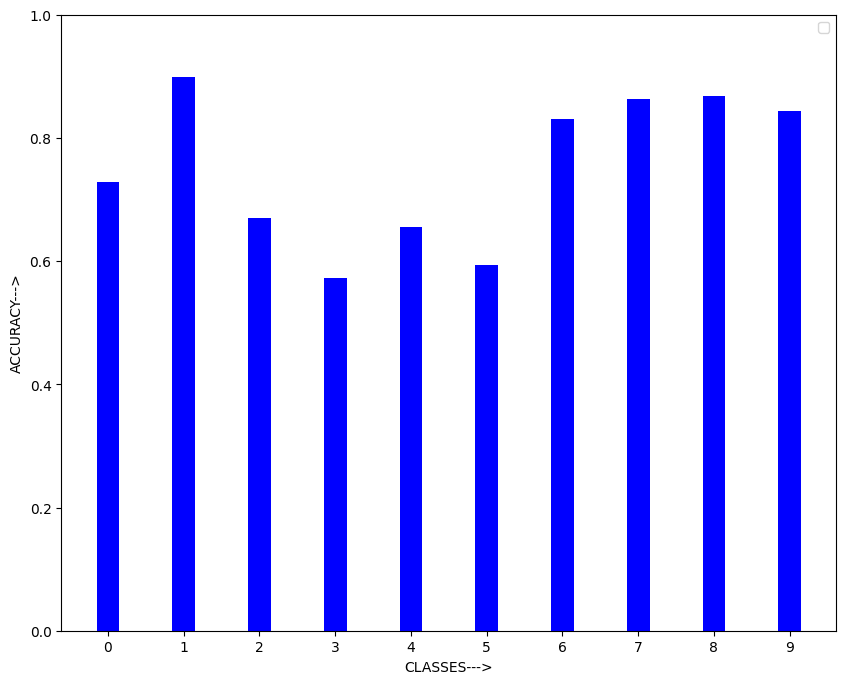

In [23]:
#CLASSWISE ACCURACY BAR-GRAPH
plt.figure(figsize=(10,8))
plt.xlabel('CLASSES--->')
plt.ylabel('ACCURACY--->')
plt.xticks(np.arange(0,10))
plt.ylim(0,1)
plt.bar(np.arange(0,10),classaccs.to('cpu'),color='blue',width=0.3)
plt.legend()
plt.show()

In [13]:
#PRINTING THE LOSSES:
print(train_loss)
print(val_loss)
train_loss = train_loss/499.84
val_loss = val_loss/10
print(train_loss)
print(val_loss)
tloss = train_loss.detach().numpy()
vloss = val_loss.detach().numpy()

tensor([2063.0823, 1493.7732, 1360.8790, 1277.8960, 1217.3474, 1171.7734,
        1134.6415, 1104.4418, 1069.6328, 1067.0950, 1042.2617, 1024.5599,
        1017.2501, 1002.0979,  996.9058,  993.9986,  979.2119,  972.8109,
         961.8384,  952.5574])
tensor([1.0122, 0.9034, 0.8368, 0.7846, 0.7763, 0.7441, 0.7496, 0.7407, 0.7204,
        0.7561, 0.6917, 0.7088, 0.7302, 0.7415, 0.7051, 0.6438, 0.6912, 0.6999,
        0.6888, 0.6911])
tensor([4.1275, 2.9885, 2.7226, 2.5566, 2.4355, 2.3443, 2.2700, 2.2096, 2.1400,
        2.1349, 2.0852, 2.0498, 2.0352, 2.0048, 1.9944, 1.9886, 1.9591, 1.9462,
        1.9243, 1.9057])
tensor([0.1012, 0.0903, 0.0837, 0.0785, 0.0776, 0.0744, 0.0750, 0.0741, 0.0720,
        0.0756, 0.0692, 0.0709, 0.0730, 0.0741, 0.0705, 0.0644, 0.0691, 0.0700,
        0.0689, 0.0691])


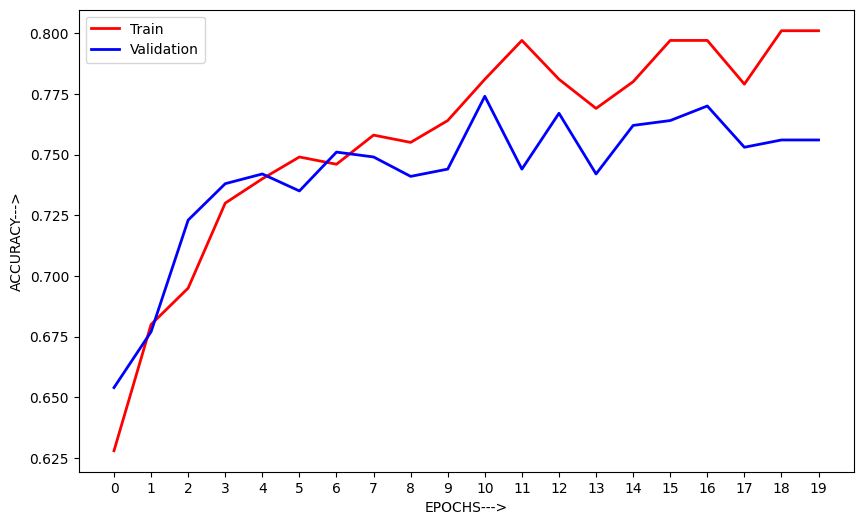

In [14]:
#CODE TO PLOT VALIDATION ACCURACY:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('ACCURACY--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, acc_t, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, acc_v, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

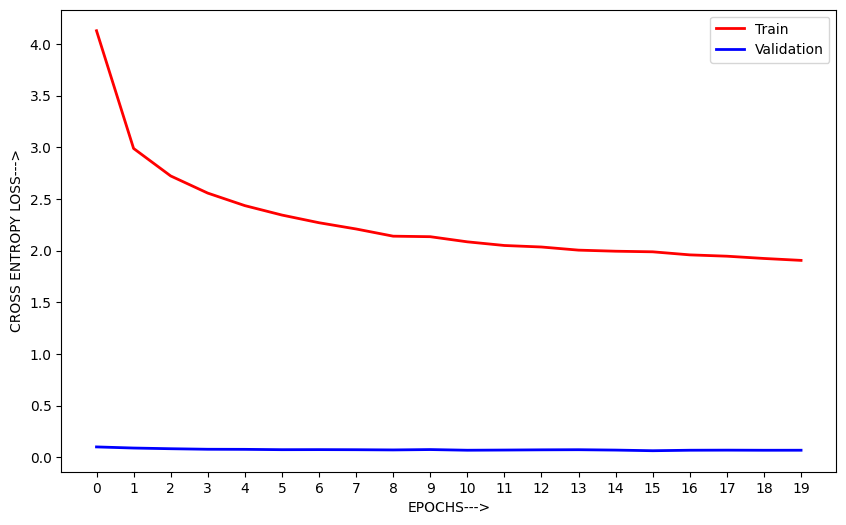

In [17]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

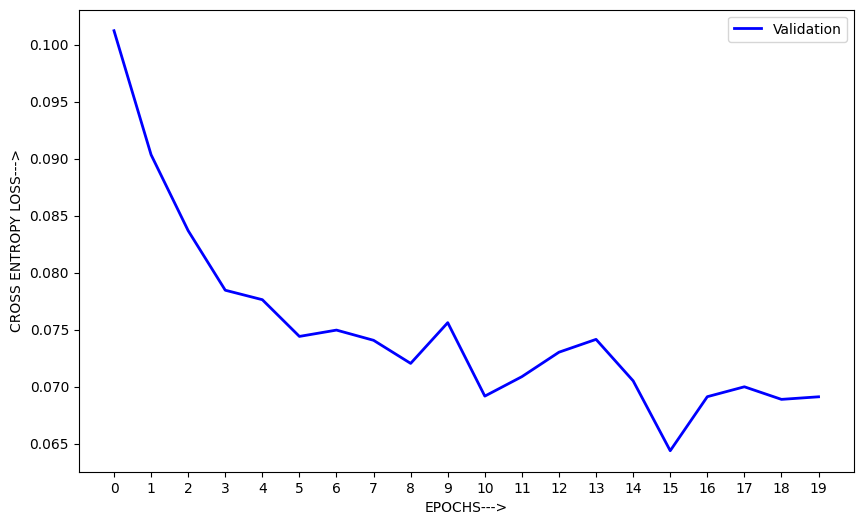

In [18]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
# plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

In [ ]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
# plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

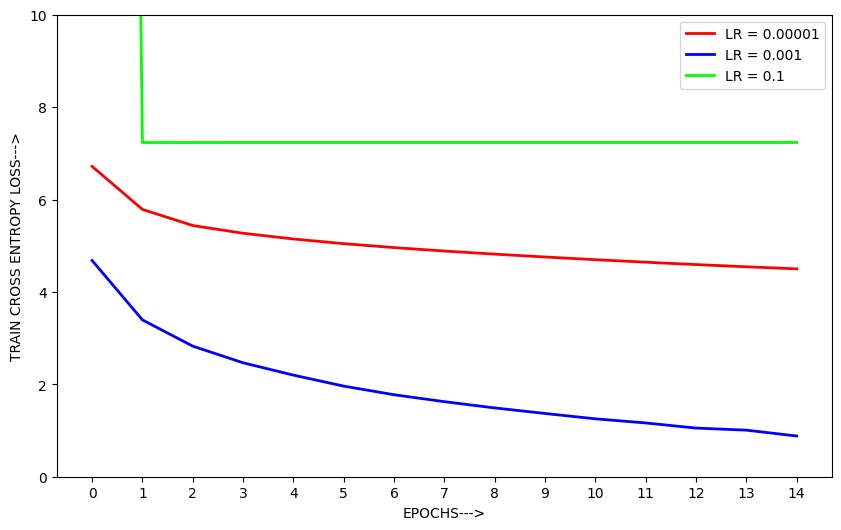

In [19]:
#COMPARING LEARNING RATES:
train_loss_00001 = np.array([6.7169, 5.7859, 5.4376, 5.2699, 5.1458, 5.0447, 4.9595, 4.8850, 4.8180,
        4.7559, 4.6978, 4.6434, 4.5919, 4.5438, 4.4993])
train_loss_001 = np.array([4.6798, 3.3941, 2.8265, 2.4660, 2.1989, 1.9609, 1.7747, 1.6242, 1.4892,
        1.3689, 1.2531, 1.1638, 1.0528, 1.0081, 0.8814, 0.8194, 0.7478, 0.7082,
        0.6791, 0.6537, 0.6183, 0.5833, 0.5416, 0.5054, 0.5074, 0.4823, 0.4684,
        0.4659, 0.4149, 0.4265, 0.4078, 0.3694, 0.3801, 0.3687, 0.3771, 0.3576,
        0.3460, 0.3161, 0.3150, 0.3330])
train_loss_01 = np.array([92.3200,  7.2332,  7.2339,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,
         7.2340,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,
         7.2340,  7.2340,  7.2340,  7.2340])
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('TRAIN CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,15)
epoch_ticks = np.arange(0,15)
plt.xticks(epoch_ticks)
plt.ylim(0,10)
plt.plot(epoch_arr, train_loss_00001[:15], 'r', label='LR = 0.00001', linewidth=2)
plt.plot(epoch_arr, train_loss_001[:15], 'b', label='LR = 0.001', linewidth=2)
plt.plot(epoch_arr, train_loss_01[:15], 'lime', label='LR = 0.1', linewidth=2)
plt.legend()
plt.show()